In [1]:
# importing libraries
import pandas as pd
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
#import statsmodels.api as sm
import numpy as np
#import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer
from sklearn import metrics, preprocessing
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils import shuffle

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# defining default data
data_dir = "/some/data-source"
saved_model_file = data_dir + "/numeric_nn_model.h5"

In [7]:
# load the datasets
df = pd.read_csv(data_dir + "/categorized.csv")
df.head(5)

,OBJ_ID,PETROR50_R,PETROR90_R,PETROMAG_U,PETROMAG_G,PETROMAG_R,PETROMAG_I,PETROMAG_Z,PETROMAGERR_U,PETROMAGERR_G,...,PETROMAGERR_MR,PETROMAGERR_MI,PETROMAGERR_MZ,PETROR50_R_KPC,REGION,PETROR50_R_KPC_SIMPLE_BIN,PETROMAG_MR_SIMPLE_BIN,REDSHIFT_SIMPLE_BIN,WVT_BIN,code
0,587722981741363294,2.695631,7.912694,19.045778,17.276037,16.401808,15.985344,15.641546,0.089137,0.013505,...,0.013804,0.014019,0.019940,3.973422,2,39.0,50.0,6.0,66.0,Sb
1,587722981741363323,3.346346,8.527256,18.523798,16.716784,15.851948,15.433319,15.155713,0.064906,0.007828,...,0.011384,0.011645,0.015903,4.071972,2,40.0,49.0,5.0,77.0,Sc
2,587722981741428877,2.589022,6.059341,18.534960,17.447456,16.872526,16.458296,16.351671,0.051412,0.010903,...,0.013081,0.013468,0.029195,5.376720,2,53.0,41.0,10.0,34.0,SBb
3,587722981741559888,3.860400,11.598755,19.545845,18.084808,17.035507,16.463684,15.881419,0.221700,0.032795,...,0.020217,0.019615,0.036172,11.628058,2,116.0,19.0,999.0,0.0,Er
4,587722981741625481,4.134207,10.662370,17.893192,16.731045,16.146350,15.823566,15.673439,0.043414,0.008893,...,0.013150,0.012796,0.025230,6.380539,2,63.0,43.0,7.0,95.0,Sc


In [8]:
# printing the shape of dataset
print("Dataset shape", df.shape)

# missing value columns
null_columns = list(col for col in df.columns if df[col].isnull().any())
print("Missing columns" , null_columns)

# count number of missing value in PETROMAG_MU
print("Number of missing values in PETROMAG_MU", df["PETROMAG_MU"].isnull().sum().sum())

Dataset shape (239100, 57)
Missing columns ['PETROMAG_MU']
Number of missing values in PETROMAG_MU 1


In [9]:
# imputing PETROMAG_MU with KNN only for 1 missing value
imputer = KNNImputer(n_neighbors=5)
columns_for_knn_impute = ["PETROMAG_MU"] 
imputed_data = imputer.fit_transform(df[columns_for_knn_impute])
tmp_df = pd.DataFrame(imputed_data, columns = columns_for_knn_impute)

df["PETROMAG_MU"] = tmp_df["PETROMAG_MU"]

In [10]:
def handle_outliers_by_groups(dframe, group_column, omit_columns):
    distinct = set(dframe[group_column].unique())
    
    for v in distinct:
        tmp_df = dframe[dframe["code"] == v]
        tmp_df = tmp_df.drop(columns=omit_columns)
        q1 = tmp_df.quantile(0.25)
        q3 = tmp_df.quantile(0.75)
        irq = q3 - q1
        lower_limit = q1 - (1.5 * irq)
        upper_limit = q3 + (1.5 * irq)
        
        # adjust the outlier value for each column
        for col in tmp_df.columns:
            tmp_df[col].astype('float64').dtypes
            dframe[col].astype('float64').dtypes
            tmp_df.loc[tmp_df[col] < lower_limit[col], col] = lower_limit[col]
            tmp_df.loc[tmp_df[col] > upper_limit[col], col] = upper_limit[col]
            dframe.loc[tmp_df.index, col] = tmp_df[col] 
            
# call and pass the dataset to handle outliers in the numerical columns    
handle_outliers_by_groups(df, "code", ["OBJ_ID", "REGION", "code"])

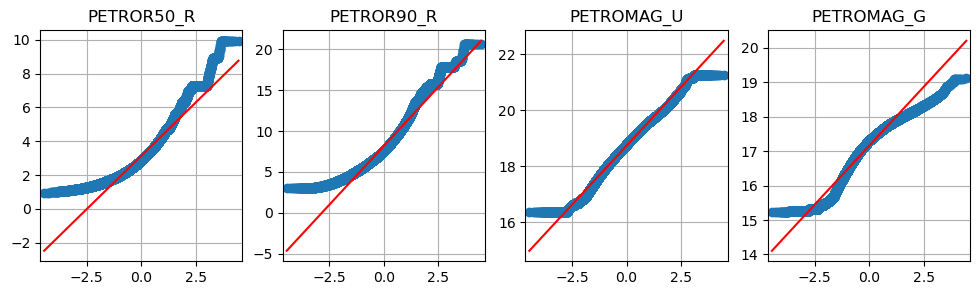

array([[<Axes: title={'center': 'PETROR50_R'}>,
        <Axes: title={'center': 'PETROR90_R'}>,
        <Axes: title={'center': 'PETROMAG_U'}>,
        <Axes: title={'center': 'PETROMAG_G'}>,
        <Axes: title={'center': 'PETROMAG_R'}>,
        <Axes: title={'center': 'PETROMAG_I'}>,
        <Axes: title={'center': 'PETROMAG_Z'}>],
       [<Axes: title={'center': 'PETROMAGERR_U'}>,
        <Axes: title={'center': 'PETROMAGERR_G'}>,
        <Axes: title={'center': 'PETROMAGERR_R'}>,
        <Axes: title={'center': 'PETROMAGERR_I'}>,
        <Axes: title={'center': 'PETROMAGERR_Z'}>,
        <Axes: title={'center': 'PSFMAG_R'}>,
        <Axes: title={'center': 'FIBERMAG_R'}>],
       [<Axes: title={'center': 'DEVMAG_R'}>,
        <Axes: title={'center': 'DEVMAGERR_R'}>,
        <Axes: title={'center': 'EXPMAG_R'}>,
        <Axes: title={'center': 'EXPMAGERR_R'}>,
        <Axes: title={'center': 'FRACDEV_R'}>,
        <Axes: title={'center': 'MU50_R'}>,
        <Axes: title={'center': 

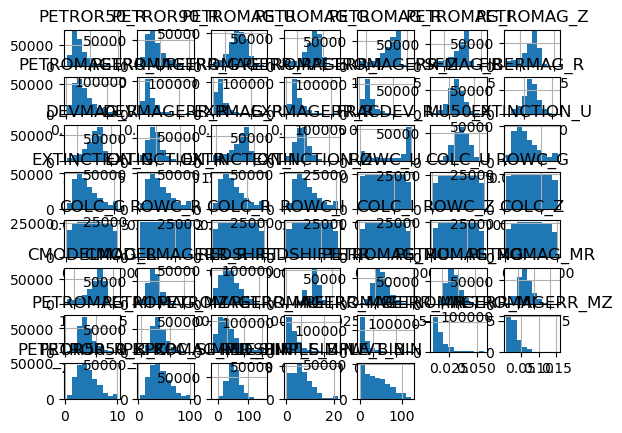

In [6]:
# Q-Q Plots and Histograms on numerical data
fig, ax = plt.subplots(1, 4, figsize=(12,3))
#fig.suptitle("Q-Q Plots")

for i in range(4):
    sm.qqplot(df[feature_cols[i]], line='s', ax=ax[i])
    ax[i].title.set_text(feature_cols[i])
    ax[i].set(xlabel='', ylabel='')
    ax[i].grid()

plt.show()

# plotting histograms to visualize
df[feature_cols].hist()

In [6]:
# to transform the column skewness

def skew_transform(dataset: pd.DataFrame, cols, strategy=np.sqrt):
    transformer = FunctionTransformer(strategy, validate=True)
    data_new = transformer.fit_transform(dataset[cols])
    tmp_df = pd.DataFrame(data_new, columns=cols)

    for col in cols:
        dataset[col] = tmp_df[col].values.tolist()

    return tmp_df

# transform columns
df = shuffle(df, random_state=42)
x_transformed = df.copy()
x_transformed = x_transformed[feature_cols]

array([[<Axes: title={'center': 'PETROR50_R'}>,
        <Axes: title={'center': 'PETROR90_R'}>,
        <Axes: title={'center': 'PETROMAG_U'}>,
        <Axes: title={'center': 'PETROMAG_G'}>,
        <Axes: title={'center': 'PETROMAG_I'}>],
       [<Axes: title={'center': 'PETROMAG_Z'}>,
        <Axes: title={'center': 'PETROMAGERR_U'}>,
        <Axes: title={'center': 'PETROMAGERR_G'}>,
        <Axes: title={'center': 'PETROMAGERR_I'}>,
        <Axes: title={'center': 'PETROMAGERR_Z'}>],
       [<Axes: title={'center': 'DEVMAGERR_R'}>,
        <Axes: title={'center': 'EXPMAGERR_R'}>,
        <Axes: title={'center': 'EXTINCTION_U'}>,
        <Axes: title={'center': 'EXTINCTION_G'}>,
        <Axes: title={'center': 'EXTINCTION_R'}>],
       [<Axes: title={'center': 'EXTINCTION_I'}>,
        <Axes: title={'center': 'EXTINCTION_Z'}>,
        <Axes: title={'center': 'CMODELMAGERR_R'}>,
        <Axes: title={'center': 'PETROMAGERR_MU'}>,
        <Axes: title={'center': 'PETROR50_R_KPC'}>],


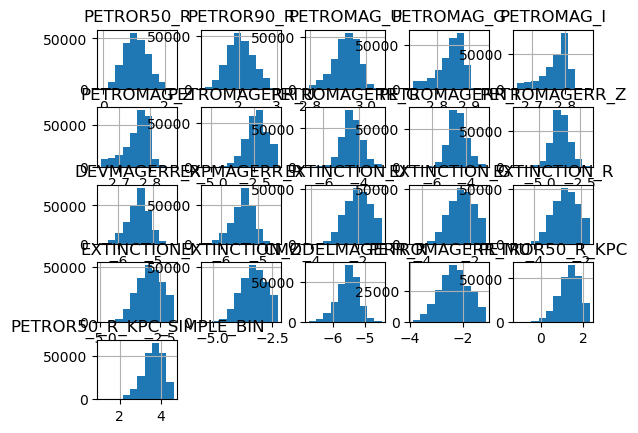

In [7]:
# right skewed log transformation
right_skewed_log_trans_cols = ["PETROR50_R", "PETROR90_R", "PETROMAG_U", "PETROMAG_G", "PETROMAG_I", "PETROMAG_Z", "PETROMAGERR_U", "PETROMAGERR_G", "PETROMAGERR_I", 
                               "PETROMAGERR_Z", "DEVMAGERR_R", "EXPMAGERR_R", "EXTINCTION_U", "EXTINCTION_G", "EXTINCTION_R", "EXTINCTION_I", "EXTINCTION_Z", "CMODELMAGERR_R",
                              "PETROMAGERR_MU", "PETROR50_R_KPC", "PETROR50_R_KPC_SIMPLE_BIN"]

skew_transform(x_transformed, right_skewed_log_trans_cols, np.log)

x_transformed[right_skewed_log_trans_cols].hist()

array([[<Axes: title={'center': 'REDSHIFTERR'}>,
        <Axes: title={'center': 'REDSHIFT_SIMPLE_BIN'}>]], dtype=object)

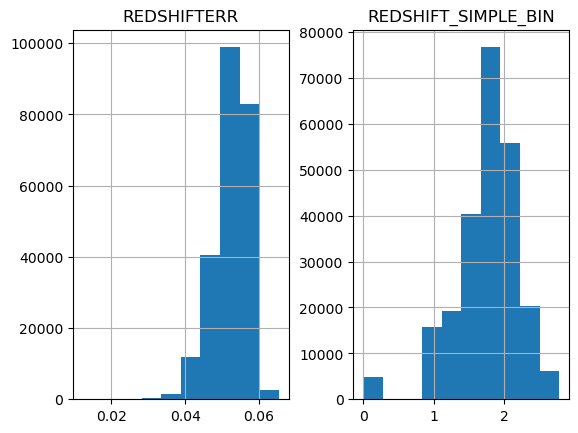

In [8]:
right_skewed_cbrt_trans_cols = ["REDSHIFTERR", "REDSHIFT_SIMPLE_BIN"]
skew_transform(x_transformed, right_skewed_cbrt_trans_cols, np.cbrt)

x_transformed[right_skewed_cbrt_trans_cols].hist()

array([[<Axes: title={'center': 'PETROMAG_R'}>,
        <Axes: title={'center': 'FRACDEV_R'}>],
       [<Axes: title={'center': 'PETROMAG_MR_SIMPLE_BIN'}>, <Axes: >]],
      dtype=object)

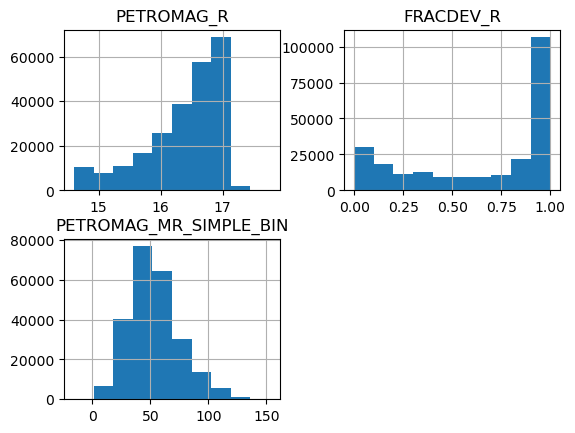

In [9]:
# left skewed data transformation

left_skewed_square_trans_cols = ["PETROMAG_R", "FRACDEV_R", "PETROMAG_MR_SIMPLE_BIN"]
skew_transform(x_transformed, right_skewed_log_trans_cols, np.cbrt)

x_transformed[left_skewed_square_trans_cols].hist()

In [10]:
std_scaler = preprocessing.StandardScaler()
scaled_values = std_scaler.fit_transform(x_transformed)
scaled_df = pd.DataFrame(scaled_values, columns=list(x_transformed.columns))

scaled_df.head(5)

,PETROR50_R,PETROR90_R,PETROMAG_U,PETROMAG_G,PETROMAG_R,PETROMAG_I,PETROMAG_Z,PETROMAGERR_U,PETROMAGERR_G,PETROMAGERR_R,...,PETROMAGERR_MU,PETROMAGERR_MG,PETROMAGERR_MR,PETROMAGERR_MI,PETROMAGERR_MZ,PETROR50_R_KPC,PETROR50_R_KPC_SIMPLE_BIN,PETROMAG_MR_SIMPLE_BIN,REDSHIFT_SIMPLE_BIN,WVT_BIN
0,1.104614,0.957476,-0.798411,-1.006806,-1.228346,-1.261923,-1.433381,-0.699784,-1.142621,-0.824703,...,-0.731916,-0.789919,-0.685394,-0.833707,-0.915103,0.957072,1.361016,-1.241698,0.500992,1.080151
1,1.215784,1.530087,-1.581742,-1.892864,-1.922352,-1.965666,-1.801273,-0.907581,-1.436386,-0.899108,...,-0.932556,-0.862895,-0.722829,-0.848554,-0.751194,0.719587,0.973313,-0.965372,-0.119880,2.278893
2,-2.352293,-1.947097,0.502549,0.369754,0.417612,0.425346,0.404349,-0.809382,-0.693124,-0.544367,...,-0.838319,-0.631292,-0.509939,-0.643464,-0.902434,-2.369874,-2.422872,1.337347,-0.693019,-0.837836
3,0.637220,1.141225,-0.441940,-1.114364,-1.644922,-1.791685,-1.921758,-0.265581,-0.916594,-0.903241,...,-0.298847,-0.718091,-0.724782,-0.876183,-1.077815,0.585747,0.733846,-1.333807,0.314599,2.141894
4,-2.012357,-1.443244,1.370746,1.073517,0.817217,0.656215,0.491281,0.680088,1.353347,1.103240,...,0.678492,1.256162,1.063734,0.924169,-0.366416,-0.489714,-0.775910,-0.182447,0.314599,-0.632337


array([[<Axes: title={'center': 'PETROR50_R'}>,
        <Axes: title={'center': 'PETROR90_R'}>,
        <Axes: title={'center': 'PETROMAG_U'}>,
        <Axes: title={'center': 'PETROMAG_G'}>,
        <Axes: title={'center': 'PETROMAG_R'}>,
        <Axes: title={'center': 'PETROMAG_I'}>,
        <Axes: title={'center': 'PETROMAG_Z'}>],
       [<Axes: title={'center': 'PETROMAGERR_U'}>,
        <Axes: title={'center': 'PETROMAGERR_G'}>,
        <Axes: title={'center': 'PETROMAGERR_R'}>,
        <Axes: title={'center': 'PETROMAGERR_I'}>,
        <Axes: title={'center': 'PETROMAGERR_Z'}>,
        <Axes: title={'center': 'PSFMAG_R'}>,
        <Axes: title={'center': 'FIBERMAG_R'}>],
       [<Axes: title={'center': 'DEVMAG_R'}>,
        <Axes: title={'center': 'DEVMAGERR_R'}>,
        <Axes: title={'center': 'EXPMAG_R'}>,
        <Axes: title={'center': 'EXPMAGERR_R'}>,
        <Axes: title={'center': 'FRACDEV_R'}>,
        <Axes: title={'center': 'MU50_R'}>,
        <Axes: title={'center': 

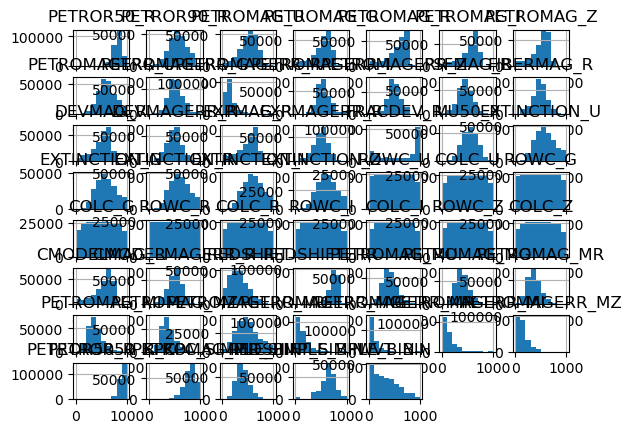

In [11]:
# Uniform strategy is used to form 1000 bins
# Notice x-axis values were transformed to positive and y-axis relatively scaled

kbins = KBinsDiscretizer(n_bins=1000, encode='ordinal', strategy='uniform')
x_discrete = kbins.fit_transform(scaled_df)
x_discrete = pd.DataFrame(x_discrete, columns=list(x_transformed.columns))
x_discrete.hist()

In [12]:
# Check whether variables has any co-relation among themselves
# The diagram below shows 0(white) = no corelation, 1(blue) = positively and -1(red) = negatively features corelated

corelation_matrix = x_discrete.corr()

plt.figure(figsize=(9,6))
#sns.heatmap(corelation_matrix, cmap='RdBu')

<Figure size 900x600 with 0 Axes>

<Figure size 900x600 with 0 Axes>

In [14]:
# taking the upper triangle for feature reduction

upper_tri = corelation_matrix.where(np.triu(np.ones(corelation_matrix.shape), k=1).astype(bool))
upper_tri.head(5)

,PETROR50_R,PETROR90_R,PETROMAG_U,PETROMAG_G,PETROMAG_R,PETROMAG_I,PETROMAG_Z,PETROMAGERR_U,PETROMAGERR_G,PETROMAGERR_R,...,PETROMAGERR_MU,PETROMAGERR_MG,PETROMAGERR_MR,PETROMAGERR_MI,PETROMAGERR_MZ,PETROR50_R_KPC,PETROR50_R_KPC_SIMPLE_BIN,PETROMAG_MR_SIMPLE_BIN,REDSHIFT_SIMPLE_BIN,WVT_BIN
PETROR50_R,NaN,0.907576,-0.547726,-0.539284,-0.474737,-0.434570,-0.351354,-0.063567,-0.045834,0.019513,...,-0.060335,0.006820,0.029622,0.078717,0.311121,0.384701,0.452049,0.060351,-0.302118,0.535867
PETROR90_R,NaN,NaN,-0.480827,-0.574286,-0.594702,-0.575862,-0.518647,0.022868,0.050064,0.112891,...,0.029294,0.108351,0.120176,0.134617,0.197123,0.365513,0.428271,-0.061804,-0.264781,0.490091
PETROMAG_U,NaN,NaN,NaN,0.898681,0.759492,0.699135,0.609959,0.799370,0.443614,0.173841,...,0.792599,0.267470,0.133209,0.129495,0.103211,0.158552,0.181084,-0.323954,0.654285,-0.434812
PETROMAG_G,NaN,NaN,NaN,NaN,0.949907,0.911934,0.845057,0.665690,0.416614,0.145657,...,0.656665,0.227598,0.102460,0.130326,0.248308,0.131442,0.158564,-0.185388,0.628292,-0.482918
PETROMAG_R,NaN,NaN,NaN,NaN,NaN,0.990733,0.958949,0.527168,0.350253,0.120293,...,0.517293,0.170898,0.078716,0.137938,0.375553,0.064561,0.080474,0.014020,0.487419,-0.449485


In [14]:
to_drop = [column for column in upper_tri.columns if any((upper_tri[column] > 0.99) | abs(upper_tri[column] < 0.01))]
print("Number of columns to be dropped -> %s out of %s" % (len(to_drop), len(x_discrete.columns)))
to_drop

Number of columns to be dropped -> 47 out of 54


['PETROMAG_U',
 'PETROMAG_G',
 'PETROMAG_R',
 'PETROMAG_I',
 'PETROMAG_Z',
 'PETROMAGERR_U',
 'PETROMAGERR_G',
 'DEVMAG_R',
 'DEVMAGERR_R',
 'EXPMAG_R',
 'EXPMAGERR_R',
 'FRACDEV_R',
 'MU50_R',
 'EXTINCTION_U',
 'EXTINCTION_G',
 'EXTINCTION_R',
 'EXTINCTION_I',
 'EXTINCTION_Z',
 'ROWC_U',
 'COLC_U',
 'ROWC_G',
 'COLC_G',
 'ROWC_R',
 'COLC_R',
 'ROWC_I',
 'COLC_I',
 'ROWC_Z',
 'COLC_Z',
 'CMODELMAG_R',
 'CMODELMAGERR_R',
 'REDSHIFT',
 'REDSHIFTERR',
 'PETROMAG_MU',
 'PETROMAG_MG',
 'PETROMAG_MR',
 'PETROMAG_MI',
 'PETROMAG_MZ',
 'PETROMAGERR_MU',
 'PETROMAGERR_MG',
 'PETROMAGERR_MR',
 'PETROMAGERR_MI',
 'PETROMAGERR_MZ',
 'PETROR50_R_KPC',
 'PETROR50_R_KPC_SIMPLE_BIN',
 'PETROMAG_MR_SIMPLE_BIN',
 'REDSHIFT_SIMPLE_BIN',
 'WVT_BIN']

In [13]:
# printing the co-relations between features
corelation_matrix

,PETROR50_R,PETROR90_R,PETROMAG_U,PETROMAG_G,PETROMAG_R,PETROMAG_I,PETROMAG_Z,PETROMAGERR_U,PETROMAGERR_G,PETROMAGERR_R,...,PETROMAGERR_MU,PETROMAGERR_MG,PETROMAGERR_MR,PETROMAGERR_MI,PETROMAGERR_MZ,PETROR50_R_KPC,PETROR50_R_KPC_SIMPLE_BIN,PETROMAG_MR_SIMPLE_BIN,REDSHIFT_SIMPLE_BIN,WVT_BIN
PETROR50_R,1.000000,0.907576,-0.547726,-0.539284,-0.474737,-0.434570,-0.351354,-0.063567,-0.045834,0.019513,...,-0.060335,0.006820,0.029622,0.078717,0.311121,0.384701,0.452049,0.060351,-0.302118,0.535867
PETROR90_R,0.907576,1.000000,-0.480827,-0.574286,-0.594702,-0.575862,-0.518647,0.022868,0.050064,0.112891,...,0.029294,0.108351,0.120176,0.134617,0.197123,0.365513,0.428271,-0.061804,-0.264781,0.490091
PETROMAG_U,-0.547726,-0.480827,1.000000,0.898681,0.759492,0.699135,0.609959,0.799370,0.443614,0.173841,...,0.792599,0.267470,0.133209,0.129495,0.103211,0.158552,0.181084,-0.323954,0.654285,-0.434812
PETROMAG_G,-0.539284,-0.574286,0.898681,1.000000,0.949907,0.911934,0.845057,0.665690,0.416614,0.145657,...,0.656665,0.227598,0.102460,0.130326,0.248308,0.131442,0.158564,-0.185388,0.628292,-0.482918
PETROMAG_R,-0.474737,-0.594702,0.759492,0.949907,1.000000,0.990733,0.958949,0.527168,0.350253,0.120293,...,0.517293,0.170898,0.078716,0.137938,0.375553,0.064561,0.080474,0.014020,0.487419,-0.449485
PETROMAG_I,-0.434570,-0.575862,0.699135,0.911934,0.990733,1.000000,0.981248,0.475600,0.319820,0.103348,...,0.465297,0.143487,0.062547,0.138929,0.419570,0.033843,0.048183,0.090869,0.420449,-0.435292
PETROMAG_Z,-0.351354,-0.518647,0.609959,0.845057,0.958949,0.981248,1.000000,0.419427,0.289556,0.090502,...,0.409451,0.120266,0.050645,0.146015,0.498157,0.030407,0.046521,0.160220,0.346214,-0.394375
PETROMAGERR_U,-0.063567,0.022868,0.799370,0.665690,0.527168,0.475600,0.419427,1.000000,0.591383,0.339483,...,0.998357,0.442565,0.299230,0.308308,0.355129,0.377149,0.443162,-0.339146,0.536369,-0.205699
PETROMAGERR_G,-0.045834,0.050064,0.443614,0.416614,0.350253,0.319820,0.289556,0.591383,1.000000,0.800273,...,0.588919,0.905678,0.748114,0.786493,0.493323,0.152547,0.178049,-0.101100,0.247129,-0.163118
PETROMAGERR_R,0.019513,0.112891,0.173841,0.145657,0.120293,0.103348,0.090502,0.339483,0.800273,1.000000,...,0.340963,0.882415,0.992828,0.877754,0.452091,0.024034,0.017873,0.046463,0.010997,-0.055964


In [14]:
# Performing PCA
# Ordering the result by varience ratio in descending order | lower values would mean high corelation among features

pca = PCA()
pca_x = pca.fit_transform(x_discrete)
df_variance_ratio = pd.DataFrame()
df_variance_ratio["features"] = x_discrete.columns.to_list()
df_variance_ratio["significance"] = pca.explained_variance_ratio_
df_variance_ratio = df_variance_ratio.sort_values(by=['significance'], ascending=False)
df_variance_ratio

,features,significance
0,PETROR50_R,2.004648e-01
1,PETROR90_R,1.989717e-01
2,PETROMAG_U,1.926456e-01
3,PETROMAG_G,1.251790e-01
4,PETROMAG_R,8.927742e-02
5,PETROMAG_I,6.940807e-02
6,PETROMAG_Z,5.297537e-02
7,PETROMAGERR_U,2.155732e-02
8,PETROMAGERR_G,1.640634e-02
9,PETROMAGERR_R,1.076620e-02


<Axes: >

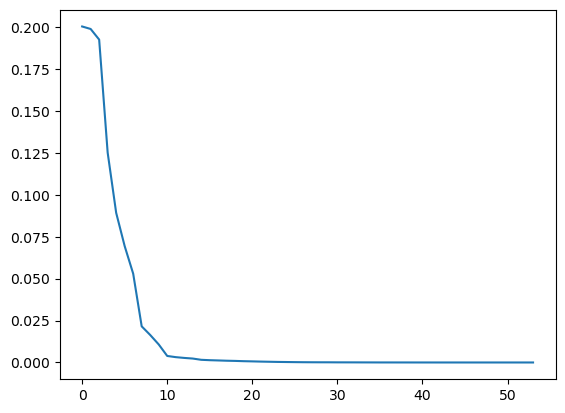

In [16]:
# Identifying significant and independent features
# Variance ratio (y-axis), number of feature(x-axis)
# After first 15 features, the ratio is nearing 0. which means the 1st 20 features more likely can be considered for building the model

df_variance_ratio["significance"].plot()

In [15]:
# split the data into train/test sets
train_X, test_X, train_y, test_y = train_test_split(x_discrete[list(df_variance_ratio["features"].head(25))], 
                                                    df["code"], test_size=0.2, random_state=42)

In [16]:
# handle sample label imbalance
counter = Counter(train_y)
print("Imbalanced sample distribution - %s" % counter)

sampler = RandomOverSampler(random_state=42)
train_X, train_y = sampler.fit_resample(train_X, train_y)
counter = Counter(train_y)
print("\nBalanced sample distribution - %s" % counter)

Imbalanced sample distribution - Counter({'Ei': 37834, 'Sc': 35476, 'Er': 31966, 'Sb': 22650, 'SBc': 20743, 'Se': 15696, 'SBb': 14739, 'Ec': 8399, 'Sd': 2471, 'SBd': 748, 'Sa': 430, 'SBa': 128})

Balanced sample distribution - Counter({'Er': 37834, 'Ei': 37834, 'Sc': 37834, 'Ec': 37834, 'SBc': 37834, 'Se': 37834, 'Sb': 37834, 'Sd': 37834, 'SBb': 37834, 'Sa': 37834, 'SBa': 37834, 'SBd': 37834})


In [17]:
# Accepts any classifier and builds and model and does the prediction on test data
def train_predict_classification(classifier, train_features, train_labels, test_features):
    # build model
    classifier.fit(train_features, train_labels)
    # predict using model
    return classifier.predict(test_features)


# Model performance is reported
def get_prediction_metrics_accuracy(true_labels, predicted_labels):
    print('Accuracy:', np.round(metrics.accuracy_score(true_labels, predicted_labels), 4))
    print('Precision:', np.round(metrics.precision_score(true_labels, predicted_labels,
                                average='weighted', zero_division=True), 4))
    print('Recall:', np.round(metrics.recall_score(true_labels, predicted_labels,
                                average='weighted', zero_division=True), 4))
    print('F1 Score:', np.round(metrics.f1_score(true_labels, predicted_labels,
                                average='weighted', zero_division=True), 4))

In [1]:
#classifier = SGDClassifier(loss='hinge', max_iter=100)
classifier = RandomForestClassifier()
#classifier = MultinomialNB()
predicted_y = train_predict_classification(classifier, train_X, train_y, test_X)
get_prediction_metrics_accuracy(test_y, predicted_y)

NameError: name 'RandomForestClassifier' is not defined

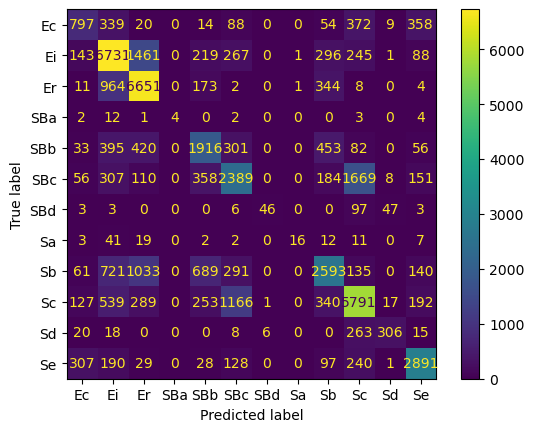

In [24]:
# draw the confusion matrix
confusion_matrix = metrics.confusion_matrix(test_y, predicted_y)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=list(classifier.classes_))
cm_display.plot()
plt.show()

In [2]:
# preparing for deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D

train_label = pd.get_dummies(train_y).values
test_label = pd.get_dummies(test_y).values

no_of_features = train_X.shape[1]
no_of_labels = len(set(train_y))

NameError: name 'train_y' is not defined

In [82]:
model = Sequential()

model.add(Conv1D(128, kernel_size=2, activation='relu', input_shape=(no_of_features, 1)))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(256, kernel_size=2, activation='relu', input_shape=(no_of_features,)))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(512, kernel_size=2, activation='relu', input_shape=(no_of_features,)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())

model.add(Dense(1024, activation='relu'))
model.add(Dense(no_of_labels, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_X, train_label, epochs=10, batch_size=64, validation_data=(test_X, test_label))

Epoch 1/10
7094/7094 [==============================] - 353s 49ms/step - loss: 1.5371 - accuracy: 0.4665 - val_loss: 1.5069 - val_accuracy: 0.4241
Epoch 2/10
7094/7094 [==============================] - 315s 44ms/step - loss: 1.0486 - accuracy: 0.5971 - val_loss: 1.3858 - val_accuracy: 0.4669
Epoch 3/10
7094/7094 [==============================] - 315s 44ms/step - loss: 0.9265 - accuracy: 0.6433 - val_loss: 1.3614 - val_accuracy: 0.4760
Epoch 4/10
7094/7094 [==============================] - 314s 44ms/step - loss: 0.8636 - accuracy: 0.6658 - val_loss: 1.3677 - val_accuracy: 0.4853
Epoch 5/10
7094/7094 [==============================] - 313s 44ms/step - loss: 0.8238 - accuracy: 0.6801 - val_loss: 1.3399 - val_accuracy: 0.5026
Epoch 6/10
7094/7094 [==============================] - 430s 61ms/step - loss: 0.7909 - accuracy: 0.6921 - val_loss: 1.3584 - val_accuracy: 0.5023
Epoch 7/10
7094/7094 [==============================] - 308s 43ms/step - loss: 0.7653 - accuracy: 0.7022 - val_loss: 1

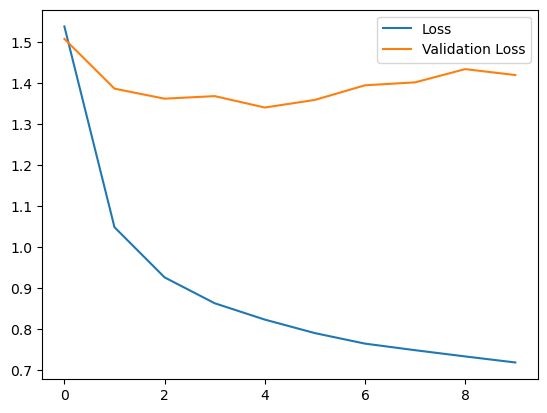

In [83]:
plt.plot(model.history['loss'], label="Loss")
plt.plot(model.history['val_loss'], label="Validation Loss")
plt.legend()
plt.show()

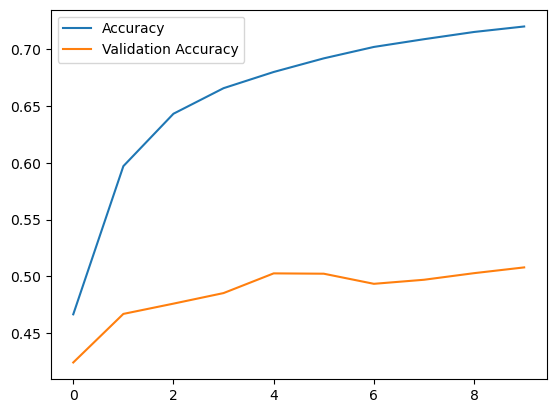

In [85]:
plt.plot(model.history['accuracy'], label="Accuracy")
plt.plot(model.history['val_accuracy'], label="Validation Accuracy")
plt.legend()
plt.show()

In [21]:
# prediction after built model
test_matrix = model.evaluate(test_X, test_label)
print('Testset Loss: {:0.3f}  Accuracy: {:0.3f}'.format(test_matrix[0], test_matrix[1]))
#model.save(saved_model_file)

In [19]:
# load the model from file and 
model = load_model(saved_model_file)
predicted_y = model.predict(test_X)

1495/1495 [==============================] - 9s 6ms/step


In [20]:
# probabilities

multi_class_preds = predicted_y.argmax(axis=1)
multi_class_preds
labels = np.array(['Ec','Ei','Er','SBa','SBb','SBc','SBd','Sa','Sb','Sc','Sd','Se'])
predicted_label = labels[multi_class_preds]
predicted_label

array(['Er', 'Er', 'Er', ..., 'SBb', 'Se', 'Sc'], dtype='<U3')

In [21]:
get_prediction_metrics_accuracy(test_y, predicted_label)

Accuracy: 0.5656
Precision: 0.5874
Recall: 0.5656
F1 Score: 0.5609


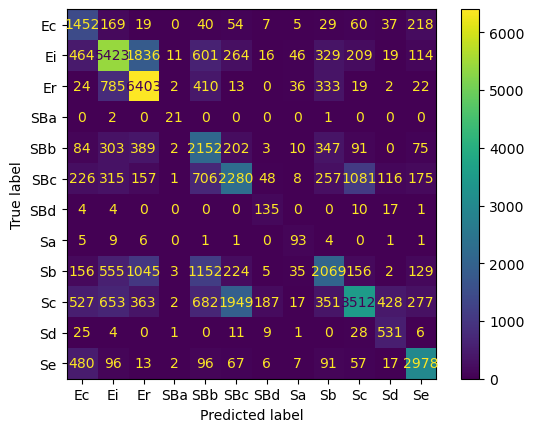

In [47]:
# draw the confusion matrix for the deep-learning neural network prediction
confusion_matrix = metrics.confusion_matrix(test_y, predicted_label)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=labels)
cm_display.plot()
plt.show()

In [82]:
# transposing the confusion matrix for statistics
confusion_matrix_df = pd.DataFrame(data=confusion_matrix)
confusion_matrix_df = confusion_matrix_df.T
confusion_matrix_df[12] = labels
confusion_matrix_df.columns = list(labels) + ['predicted_y']
confusion_matrix_df

,Ec,Ei,Er,SBa,SBb,SBc,SBd,Sa,Sb,Sc,Sd,Se,predicted_y
0,1452,464,24,0,84,226,4,5,156,527,25,480,Ec
1,169,5423,785,2,303,315,4,9,555,653,4,96,Ei
2,19,1836,6403,0,389,157,0,6,1045,363,0,13,Er
3,0,11,2,21,2,1,0,0,3,2,1,2,SBa
4,40,601,410,0,2152,706,0,1,1152,682,0,96,SBb
5,54,264,13,0,202,2280,0,1,224,1949,11,67,SBc
6,7,16,0,0,3,48,135,0,5,187,9,6,SBd
7,5,46,36,0,10,8,0,93,35,17,1,7,Sa
8,29,329,333,1,347,257,0,4,2069,351,0,91,Sb
9,60,209,19,0,91,1081,10,0,156,3512,28,57,Sc


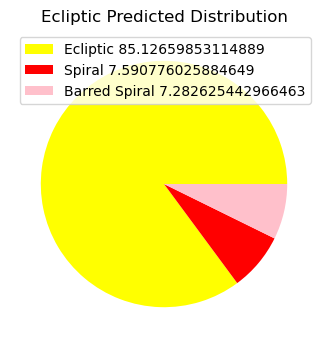

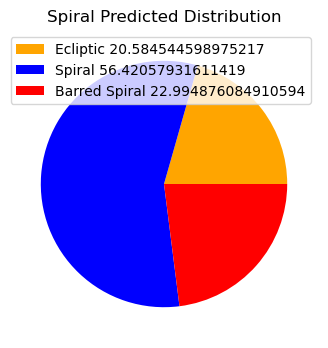

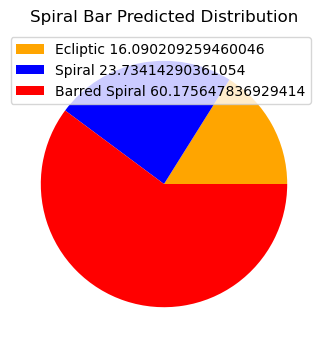

In [187]:
def main_group_summary(cm_df, base_group = [], query_group = []):
    
    col_sums = pd.DataFrame(cm_df.sum(axis='rows', numeric_only=True)).T
    
    q = " | ".join([("predicted_y=='%s'" % g) for g in query_group])
    tmp_df = cm_df.query(q)
    
    # number of predicted from query group
    num_predicted = pd.DataFrame(tmp_df[base_group].sum()).sum()[0]
    
    # find the base group total from the true labels
    group_total = col_sums[base_group].sum(axis='columns')[0]
    return (num_predicted/group_total * 100)
    

# define groups    
ecliptic_grp = ["Ec", "Ei", "Er"]
spiral_grp = ["Sa", "Sb", "Sc", "Sd", "Se"]
spiral_bar_grp = ["SBa", "SBb", "SBc", "SBd"]

# calculate ecliptic stats
stat = []
stat.append(main_group_summary(confusion_matrix_df, base_group=ecliptic_grp, query_group=ecliptic_grp))
stat.append(main_group_summary(confusion_matrix_df, base_group=ecliptic_grp, query_group=spiral_grp))
stat.append(main_group_summary(confusion_matrix_df, ecliptic_grp, spiral_bar_grp))
plt.figure(figsize=(6,4))
plt.title("Ecliptic Predicted Distribution")
plt.pie(stat, colors=['yellow', 'red', 'pink'])
plt.legend(labels=["Ecliptic %s" % stat[0], "Spiral %s" % stat[1], "Barred Spiral %s" % stat[2]], loc='best')
plt.show()

stat = []
stat.append(main_group_summary(confusion_matrix_df, base_group=spiral_grp, query_group=ecliptic_grp))
stat.append(main_group_summary(confusion_matrix_df, base_group=spiral_grp, query_group=spiral_grp))
stat.append(main_group_summary(confusion_matrix_df, spiral_grp, spiral_bar_grp))
plt.figure(figsize=(6,4))
plt.title("Spiral Predicted Distribution")
plt.pie(stat, colors=['orange', 'blue', 'red'])
plt.legend(labels=["Ecliptic %s" % stat[0], "Spiral %s" % stat[1], "Barred Spiral %s" % stat[2]], loc='best')
plt.show()

stat = []
stat.append(main_group_summary(confusion_matrix_df, spiral_bar_grp, query_group=ecliptic_grp))
stat.append(main_group_summary(confusion_matrix_df, spiral_bar_grp, query_group=spiral_grp))
stat.append(main_group_summary(confusion_matrix_df, spiral_bar_grp, spiral_bar_grp))
plt.figure(figsize=(6,4))
plt.title("Spiral Bar Predicted Distribution")
plt.pie(stat, colors=['orange', 'blue', 'red'])
plt.legend(labels=["Ecliptic %s" % stat[0], "Spiral %s" % stat[1], "Barred Spiral %s" % stat[2]], loc='best')
plt.show()